In [1]:
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D


%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


## Data Loading and Preparation

In [2]:
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [3]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000] #these are the 20k with the HIGHEST READ COUNT
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

label_e_train = e_train['scaled_rl']
label_e_test = e_test['rl']

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Calculate / Load MFE Calculations for All Data Points

In [4]:
get_mfe = lambda s: RNA.fold(s)[1]
upstream_constant = "GGGACATCGTAGAGAGTCGTACTTA"
eGFP = "ATGGGCGAATTAAGTAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAAAGCTAGC"
downstream_addition = "GCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTG"

def get_start_subseq(utr,n_bp=75):
    seq = upstream_constant+utr+eGFP+downstream_addition
    return seq[:min(n_bp,len(seq))]

In [5]:
# data = pd.DataFrame([df['utr'],df['rl']]).transpose()

# data['scaled_rl'] = preprocessing.StandardScaler().fit_transform(data['rl'].values.reshape(-1,1))
# print 'finished rescale'
# data['mfe75'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,75))) #just constant region + random region
# print 'finished 75'
# data['mfe100'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,100)))
# print 'finished 100'
# data['mfe125'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,125)))
# print 'finished 125'

# data.to_csv('../mfe_dataset.csv')

data = pd.read_csv('../mfe_dataset.csv',index_col=0)
data.head(2)

,utr,rl,scaled_rl,mfe75,mfe100,mfe125
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,3.039939,-2.130922,-16.0,-24.700001,-34.799999
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,3.895109,-1.600332,-14.4,-25.600000,-36.400002


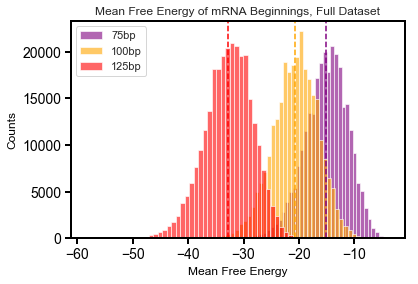

In [6]:
# Display MFE Distributions
fig,ax = plt.subplots()
ax.hist(data['mfe75'].values,color='purple',bins=50,alpha=0.6,label='75bp')
ax.axvline(np.mean(data['mfe75'].values),color='purple',linestyle="--")
ax.hist(data['mfe100'].values,color='orange',bins=50,alpha=0.6,label='100bp')
ax.axvline(np.mean(data['mfe100'].values),color='orange',linestyle="--")
ax.hist(data['mfe125'].values,color='red',bins=50,alpha=0.6,label='125bp')
ax.axvline(np.mean(data['mfe125'].values),color='red',linestyle="--")
ax.set_title("Mean Free Energy of mRNA Beginnings, Full Dataset")
ax.set_xlabel('Mean Free Energy')
ax.set_ylabel("Counts")
ax.legend()

## Construct Model

Use a more compact model than the authors' original, but ideally still reasonable r2 values

In [7]:
def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dilation1=3, dilation2=1, dilation3=1, 
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), dilation_rate=dilation1,
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), dilation_rate=dilation2,
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), dilation_rate=dilation3, 
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [34]:
# model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3, border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=15, filter_len=8,
#                     dilation1=1, dilation2=4,
#                     dropout1=0, dropout2=0,dropout3=0.2)

W0823 22:28:05.126591 4450448832 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 22:28:05.162580 4450448832 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 22:28:05.170793 4450448832 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 22:28:05.276021 4450448832 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0823 22:28:05.284399 4450448832 deprecati

Epoch 1/3
260000/260000 [==============================] - 21s 82us/step - loss: 0.3784
Epoch 2/3
260000/260000 [==============================] - 19s 75us/step - loss: 0.2210
Epoch 3/3
260000/260000 [==============================] - 19s 72us/step - loss: 0.1685


In [35]:
# e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
# r = r2(e_test['rl'], e_test['pred'])
# print 'r-squared = ', r

r-squared =  0.9143350584632816


In [37]:
# Save model
# name = 'base_efficient_CNN_model.hdf5'
# model.save('./saved_models/'+name)

## What happens if we visualize model performance on ALL the data, not just the test set?

In [8]:
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5')

W0828 11:23:21.711072 4565497280 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 11:23:21.826822 4565497280 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 11:23:21.879242 4565497280 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 11:23:21.975301 4565497280 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 11:23:21.982738 4565497280 deprecati

In [9]:
# Test Dataset
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9338504476208073


In [10]:
# Entire Dataset
data = pd.read_csv('../mfe_dataset.csv',index_col=0)
seq_data = one_hot_encode(data,seq_len=50)
data = test_data(df=data, model=model, obs_col='rl',test_seq=seq_data)
r = r2(data['rl'], data['pred'])
print 'r-squared = ', r

r-squared =  0.8996725996764278


In [11]:
# Train Dataset
e_train = test_data(df=e_train, model=model, obs_col='rl', test_seq=seq_e_train)
r = r2(e_train['rl'], e_train['pred'])
print 'r-squared = ', r

r-squared =  0.8941933452903729


In [12]:
# Make Function for Reuseability
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred'):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


Train is blue, Test is red


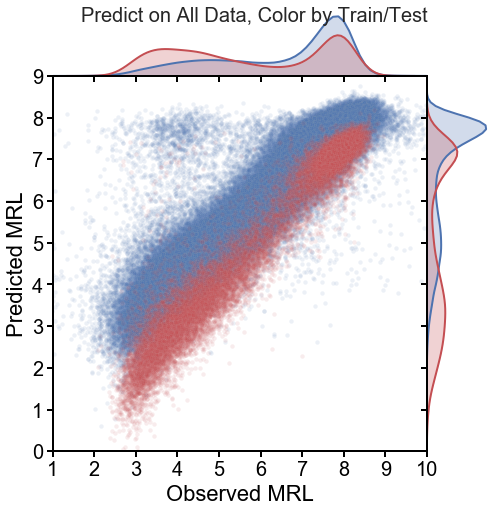

In [13]:
# Visualize Model performance on Test vs Train Datasets
train_test_plot = jointgrid_plot([e_train,e_test],title='Predict on All Data, Color by Train/Test')
print "Train is blue, Test is red"

In [14]:
# Try to isolate that off-diagonal "cluster" of low observed/high predicted MRL
od_cluster = data[((data['pred']-data['rl'])**2 > 3.5)&(data['pred']-data['rl'] > 0)&(data['pred'] > 6.5)] 
len(od_cluster)

1265

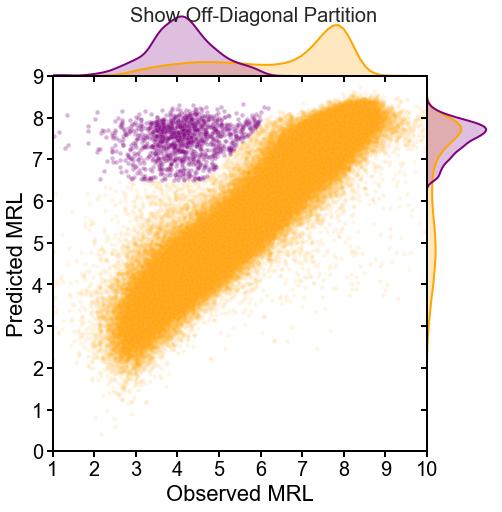

In [15]:
rest_of_data = data[~data['utr'].isin(od_cluster['utr'].values)]
od_plot = jointgrid_plot([rest_of_data,od_cluster],colors=['orange','purple'],
               title="Show Off-Diagonal Partition",alphas=[0.1,0.3])

In [16]:
d = df[df['utr'].isin(od_cluster['utr'].values)]
print np.mean(d['total_reads']), "\t",'full dataset off-diagonal average read count'
print np.mean(e_test['total_reads']), "\t\t",'test dataset average read count'
print np.mean(e_train['total_reads']), "\t\t", 'train dataset average read count'
print np.mean(e_test[e_test['utr'].isin(od_cluster['utr'].values)]['total_reads']),"\t", 'test dataset off-diagonal average read count'
print
print "Okay, off-diagonals are NOT there just for lack of reads. good to know."

971.5691699604743 	full dataset off-diagonal average read count
3185.96415 		test dataset average read count
1070.73505 		train dataset average read count
3098.3396226415093 	test dataset off-diagonal average read count

Okay, off-diagonals are NOT there just for lack of reads. good to know.


### So, what's special about these points?  

In [19]:
# Save off-diagonal cluster points
od_cluster.to_csv('../off_diagonal_utrs_author_model_all_data.csv')
ods = od_cluster

### Can I color that same plot by stratified MFE?

Maybe the off-diagonal cluster has more secondary structure, and the model doesn't handle it well?

In [20]:
# Optionally Color by Custom Stratifications (rather than quartile splits, seen below)
# blue_mfe = data[data['mfe125'] > -30]
# green_mfe = data[(data['mfe125'] < -30) & (data['mfe125'] > -35)]
# orange_mfe = data[(data['mfe125'] < -35) & (data['mfe125'] >= -40)]
# red_mfe = data[data['mfe125'] < -40]

# print "Blue:", len(blue_mfe)
# print "Green:", len(green_mfe)
# print "Orange:", len(orange_mfe)
# print "Red:", len(red_mfe)

# mfe125_plot = jointgrid_plot([blue_mfe,green_mfe,orange_mfe,red_mfe],
#                             colors=['blue','green','orange','red'],
#                             alphas=[0.1,0.05,0.05,0.1],
#                             title="MFE, 125bp")

# Train Models on Stratified MFE

Start by splitting the dataset in a rational way

In [24]:
# Stratify based on the 100bp MFE 
data.sort_values('mfe100',inplace=True,ascending=False)
data.reset_index(inplace=True,drop=True)

highest_qt = data.iloc[:70000] #these have the least negative/highest MFE => least 2ndary structure
nexthigh_qt = data.iloc[70000:140000]
nextlow_qt = data.iloc[140000:210000]
lowest_qt = data.iloc[210000:] #these have the lowest MFE => highest 2ndary structure

high_half = data.iloc[:140000]
low_half = data.iloc[140000:]

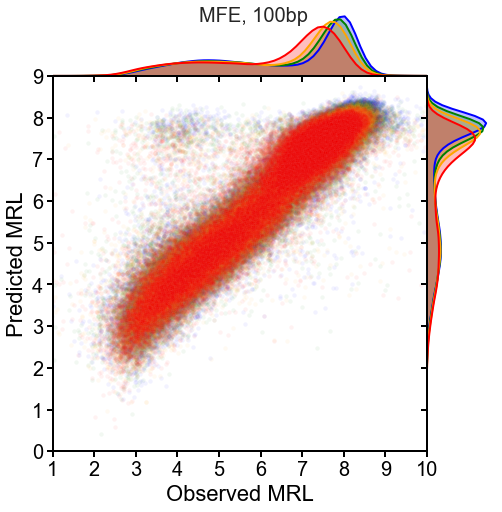

In [25]:
# Visualize
d,c = [highest_qt,nexthigh_qt,nextlow_qt,lowest_qt],['blue','green','orange','red']
mfe100_plot = jointgrid_plot(d,colors=c,alphas=[0.05,0.05,0.05,0.05],title="MFE, 100bp")

In [26]:
# Shuffle the datasets before splitting between train and test
np.random.seed(1337)
high_half.sample(frac=1).reset_index(drop=True)
low_half.sample(frac=1).reset_index(drop=True)

high_train = high_half.iloc[:120000]
high_test = high_half.iloc[120000:]
low_train = low_half.iloc[:120000]
low_test = low_half.iloc[120000:]

seq_high_train = one_hot_encode(high_train,seq_len=50)
seq_low_train = one_hot_encode(low_train, seq_len=50)
seq_high_test = one_hot_encode(high_test,seq_len=50)
seq_low_test = one_hot_encode(low_test, seq_len=50)

seq_ods_test = one_hot_encode(ods, seq_len=50)

In [27]:
np.random.seed(1337)
high_model = train_model(seq_high_train, high_train['scaled_rl'], nb_epoch=5, border_mode='same',
                    inp_len=50, nodes=40, layers=3, nbr_filters=40, filter_len=8,
                    dilation1=1, dilation2=4,
                    dropout1=0, dropout2=0,dropout3=0.2)

Epoch 1/5
120000/120000 [==============================] - 21s 176us/step - loss: 0.4389
Epoch 2/5
120000/120000 [==============================] - 19s 160us/step - loss: 0.2057
Epoch 3/5
120000/120000 [==============================] - 19s 159us/step - loss: 0.1554
Epoch 4/5
120000/120000 [==============================] - 19s 159us/step - loss: 0.1391
Epoch 5/5
120000/120000 [==============================] - 19s 160us/step - loss: 0.1313


In [28]:
high_test = test_data(df=high_test, model=high_model, obs_col='rl',test_seq=seq_high_test,output_col='high_pred')
r = r2(high_test['rl'].astype('float'), high_test['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/high mfe r-squared = ', r

high model/high mfe r-squared =  0.8869856468440838


In [29]:
low_test = test_data(df=low_test, model=high_model, obs_col='rl',test_seq=seq_low_test,output_col='high_pred')
r = r2(low_test['rl'].astype('float'), low_test['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/low mfe r-squared = ', r

high model/low mfe r-squared =  0.8325615587983043


In [31]:
ods = test_data(df=ods, model=high_model, obs_col='rl',test_seq=seq_ods_test,output_col='high_pred')
r = r2(ods['rl'].astype('float'), ods['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/off-diagonal cluster r-squared = ', r

high model/off-diagonal cluster r-squared =  0.011901707491194988


In [32]:
np.random.seed(1337)
low_model = train_model(seq_low_train, low_train['scaled_rl'], nb_epoch=5, border_mode='same',
                    inp_len=50, nodes=40, layers=3, nbr_filters=40, filter_len=8,
                    dilation1=1, dilation2=4,
                    dropout1=0, dropout2=0,dropout3=0.2)

Epoch 1/5
120000/120000 [==============================] - 23s 188us/step - loss: 0.3924
Epoch 2/5
120000/120000 [==============================] - 19s 160us/step - loss: 0.1918
Epoch 3/5
120000/120000 [==============================] - 20s 164us/step - loss: 0.1510
Epoch 4/5
120000/120000 [==============================] - 19s 160us/step - loss: 0.1375
Epoch 5/5
120000/120000 [==============================] - 19s 161us/step - loss: 0.1301


In [33]:
high_test = test_data(df=high_test, model=low_model, obs_col='rl',test_seq=seq_high_test,output_col='low_pred')
r = r2(high_test['rl'].astype('float'), high_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/high mfe r-squared = ', r

low model/high mfe r-squared =  0.8898130857164541


In [34]:
low_test = test_data(df=low_test, model=low_model, obs_col='rl',test_seq=seq_low_test,output_col='low_pred')
r = r2(low_test['rl'].astype('float'), low_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/low mfe r-squared = ', r

low model/low mfe r-squared =  0.8402832683878062


In [36]:
ods = test_data(df=ods, model=low_model, obs_col='rl',test_seq=seq_ods_test,output_col='low_pred')
r = r2(ods['rl'].astype('float'), ods['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/off-diagonal cluster r-squared = ', r

low model/off-diagonal cluster r-squared =  0.01869488301856082


In [37]:
# Try testing on just the lowest-MFE global quartile of sequences (most structure)
seq_lowest_test = one_hot_encode(lowest_qt,seq_len=50)
seq_highest_test = one_hot_encode(highest_qt,seq_len=50)

lowest_test = test_data(df=lowest_qt, model=high_model, obs_col='rl',test_seq=seq_lowest_test,output_col='high_pred')
r = r2(lowest_test['rl'].astype('float'), lowest_test['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/lowest quartile mfe r-squared = ', r

high model/lowest quartile mfe r-squared =  0.8584785573958323


In [38]:
lowest_test = test_data(df=lowest_qt, model=low_model, obs_col='rl',test_seq=seq_lowest_test,output_col='low_pred')
r = r2(lowest_test['rl'].astype('float'), lowest_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/lowest quartile mfe r-squared = ', r

low model/lowest quartile mfe r-squared =  0.8749583060606226


In [39]:
highest_test = test_data(df=highest_qt, model=high_model, obs_col='rl',test_seq=seq_highest_test,output_col='high_pred')
r = r2(highest_test['rl'].astype('float'), highest_test['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/highest quartile mfe r-squared = ', r

high model/highest quartile mfe r-squared =  0.9121393120668682


In [40]:
highest_test = test_data(df=highest_qt, model=low_model, obs_col='rl',test_seq=seq_highest_test,output_col='low_pred')
r = r2(highest_test['rl'].astype('float'), highest_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/highest quartile mfe r-squared = ', r

low model/highest quartile mfe r-squared =  0.899779763847451


In [57]:
ods = test_data(df=ods, model=model, obs_col='rl',test_seq=seq_ods_test,output_col='auth_pred')
r = r2(ods['rl'].astype('float'), ods['auth_pred'].astype('float')) #not sure why typecast is needed?
print 'author model/off-diagonal cluster r-squared = ', r

author model/off-diagonal cluster r-squared =  0.035084117045076094


Text(0.5,0.98,'Testing High- and Low-Trained Models Against Off-Diagonal Cluster')

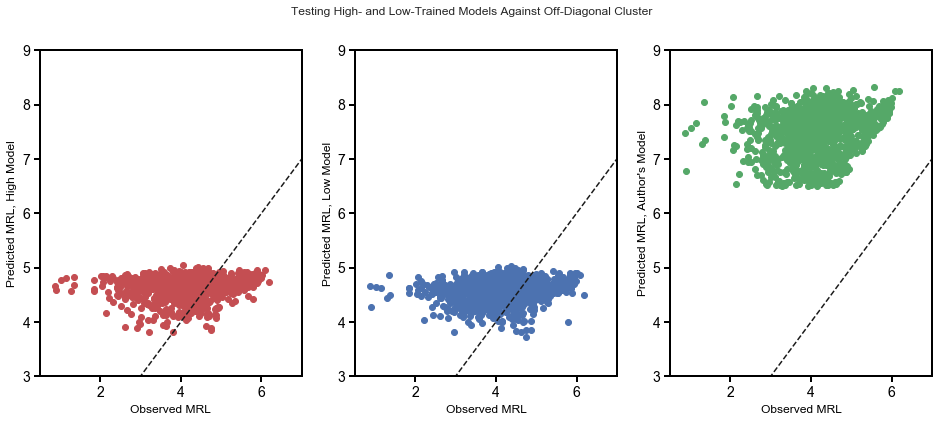

In [58]:
f,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(16,6))
ax1.scatter(ods['rl'],ods['high_pred'],color='r')
ax2.scatter(ods['rl'],ods['low_pred'],color='b')
ax3.scatter(ods['rl'],ods['pred'],color='g')
ax1.plot(range(10),range(10),color='k',linestyle="--")
ax2.plot(range(10),range(10),color='k',linestyle="--")
ax3.plot(range(10),range(10),color='k',linestyle="--")
ax1.set_xlabel("Observed MRL")
ax2.set_xlabel("Observed MRL")
ax3.set_xlabel("Observed MRL")
ax1.set_ylabel("Predicted MRL, High Model")
ax2.set_ylabel("Predicted MRL, Low Model")
ax3.set_ylabel("Predicted MRL, Author's Model")
ax1.set_xlim(0.5,7.01)
ax2.set_xlim(0.5,7.01)
ax3.set_xlim(0.5,7.01)
ax1.set_ylim(3,9)
ax2.set_ylim(3,9)
ax3.set_ylim(3,9)
f.suptitle("Testing High- and Low-Trained Models Against Off-Diagonal Cluster")

### What is going on here? Why is the R2 better for the author's model than the high and low models, when the clusters are in super different places?

## Analyze 2ndary Structure of Shared Off-Diagonal Sequences

Prediction: they have more structure, statistically, than on-diagonal sequences

In [76]:
shared_off_diagonals = pd.read_csv('../off_diagonal_utrs_shared.csv')

In [14]:
for seq in shared_off_diagonals['utr'].values[:5]:      
    # compute minimum free energy (MFE) and corresponding structure
    (ss, mfe) = RNA.fold(seq)
    # print output
    print "%s\n%s [ %6.3f ]\n" % (seq, ss, mfe)
    
get_mfe = lambda s: RNA.fold(s)[1]
shared_off_diagonals['mfe'] = [ get_mfe(s) for s  in shared_off_diagonals['utr'].values ]

AAACGCGGTGGATCACGGCCAGCTAGAGGGCGAAGGCGTCCTTCCACCAG
......((((((.....(((.(((....)))...))).....)))))).. [ -18.100 ]

ACAAAAACATTGACATGATCGGATACAGGCGGCGTACGGCATGCGCTACC
...........................((.((((((.....)))))).)) [ -8.100 ]

AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG
...........((.......))(((((((((.(.....).))))))))). [ -13.600 ]

ATCAGGGCTAGATTAATACGTAGCTCAGACAGTTATATTGAATCACCTGA
.(((((......(((((..((((((.....)))))))))))....))))) [ -9.100 ]

CAATAGGCAGGTGCGCGCTACGCGCGGGATTCCTAGACCACTCGGTCAAT
...((((....(.(((((...))))).)...))))((((....))))... [ -17.300 ]



#### Note: The paper actually used an upstream constant segment as well. Include in varying amounts in MFE calculation!

In [26]:
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5') # load the author's model

In [138]:
# # reset e_test
# np.random.seed(1337)
# e_test = df.iloc[:20000]
# e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
# r = r2(e_test['rl'], e_test['pred'])
# print 'r-squared = ', r

In [28]:
# data = pd.DataFrame([e_test['utr'],e_test['rl'],e_test['pred']]).transpose()
# data['pct_error'] = 100*np.abs(data['pred'] - data['rl'])/data['rl']

In [80]:
# upstream_constant = "GGGACATCGTAGAGAGTCGTACTTA"
# eGFP = "ATGGGCGAATTAAGTAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAAAGCTAGC"
# downstream_addition = "GCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTG"

# def get_start_subseq(utr,n_bp=75):
#     seq = upstream_constant+utr+eGFP+downstream_addition
#     return seq[:min(n_bp,len(seq))]

# data['mfe50'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,50)))
# data['mfe75'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,75))) #just constant region + random region
# data['mfe100'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,100)))
# data['mfe150'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,150)))

In [139]:
set_shared = pd.read_csv('../off_diagonal_utrs_shared.csv',index_col=0)

In [140]:
data['is_offdiag'] = data['utr'].apply(lambda s: s in set_shared)
data.head()

,Unnamed: 0,utr,rl,scaled_rl,mfe75,mfe100,mfe125,pred,is_offdiag
0,0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,3.039939,-2.130922,-16.0,-24.700001,-34.799999,3.049609,False
1,1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,3.895109,-1.600332,-14.4,-25.600000,-36.400002,4.013478,False
2,2,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA,3.334524,-1.948147,-12.6,-20.200001,-30.500000,3.785102,False
3,3,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGTAAAC,3.575082,-1.798893,-11.4,-19.100000,-29.100000,3.741681,False
4,4,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTCCGCC,4.593712,-1.166885,-17.5,-26.100000,-36.700001,4.809417,False


## Sample with Replacement for Statistical Analysis

### First 50 base pairs

mean: -7.895555612776015 std: 2.585941126852101


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 50 bp')

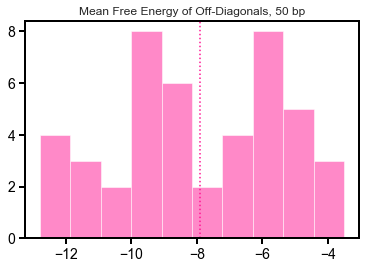

In [111]:
test50_values = data[data['is_offdiag'] == True]['mfe50'].values
test50_mean = np.mean(test50_values)
test50_std = np.std(test50_values)
print "mean:", test50_mean, "std:", test50_std
fig,ax = plt.subplots()
ax.hist(test50_values,color='deeppink',bins=10,alpha=0.5)
ax.axvline(test50_mean,color='deeppink',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 50 bp")

Sample mean: -7.895555612776015
Population mean: -8.597367563252977


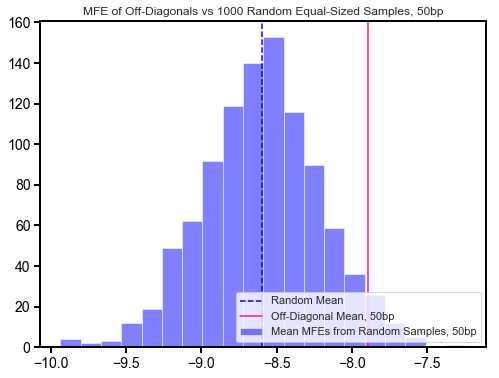

In [112]:
pop50_means = np.zeros(1000)
pop50_stds = np.zeros(1000)

np.random.seed(1336)
for i in range(1000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(shared_off_diagonals))
    mfes = data.iloc[indices]['mfe50'].values
    pop50_means[i],pop150_stds[i] = np.mean(mfes),np.std(mfes)
    
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop50_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 50bp')
ax.axvline(np.mean(pop50_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test50_mean,color='deeppink',label='Off-Diagonal Mean, 50bp')
ax.set_title("MFE of Off-Diagonals vs 1000 Random Equal-Sized Samples, 50bp")
ax.legend(loc='lower right')
print "Sample mean:", test50_mean
print "Population mean:", np.mean(pop50_means)

In [84]:
count_more_extreme50 = np.count_nonzero(pop50_means < test50_mean)
print count_more_extreme50
n = (1-(count_more_extreme50/1000.0))*100
print "The mean MFE of the 45 off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement from the same population of sequences"


959
The mean MFE of the 45 off-diagonal sequences is lower than 4.1 % of the means 
 obtained by sampling randomly with replacement from the same population of sequences


### First 75 base pairs (aka upstream constant region plus variable region)

In [86]:
test75_values = data[data['is_offdiag'] == True]['mfe75'].values
test75_mean = np.mean(test75_values)
test75_std = np.std(test75_values)
print "mean:", test75_mean, "std:", test75_std

mean: -16.344444508022733 std: 4.880690053766691


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 75 bp')

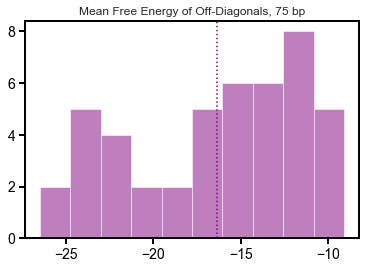

In [87]:
fig,ax = plt.subplots()
ax.hist(test75_values,color='purple',bins=10,alpha=0.5)
ax.axvline(test75_mean,color='purple',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 75 bp")

In [88]:
pop75_means = np.zeros(1000)
pop75_stds = np.zeros(1000)

np.random.seed(1337)
for i in range(1000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(e_test)),len(shared_off_diagonals))
    mfes = data.iloc[indices]['mfe75'].values
    pop75_means[i],pop75_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 500 == 0:
        print i+1
   

500
1000


Sample mean: -16.344444508022733
Population mean: -15.21443800412284


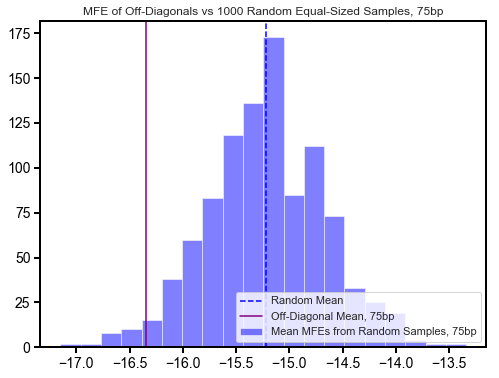

In [89]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop75_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 75bp')
ax.axvline(np.mean(pop75_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test75_mean,color='purple',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of Off-Diagonals vs 1000 Random Equal-Sized Samples, 75bp")
ax.legend(loc='lower right')
print "Sample mean:", test75_mean
print "Population mean:", np.mean(pop75_means)

In [91]:
count_more_extreme75 = np.count_nonzero(pop75_means < test75_mean)
print count_more_extreme75
n = (1-(count_more_extreme75/1000.0))*100
print "The mean MFE of the 45 off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement from the same population of sequences"


The mean MFE of the 45 off-diagonal sequences is lower than 97.6 % of the means 
 obtained by sampling randomly with replacement from the same population of sequences


### First 100 base pairs

mean: -21.75555551317003 std: 4.567399155158655


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 100 bp')

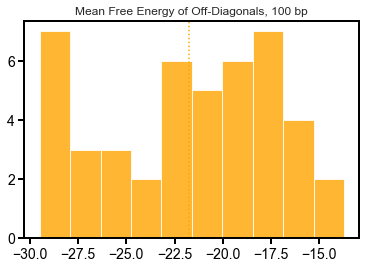

In [92]:
test100_values = data[data['is_offdiag'] == True]['mfe100'].values
test100_mean = np.mean(test100_values)
test100_std = np.std(test100_values)
print "mean:", test100_mean, "std:", test100_std
fig,ax = plt.subplots()
ax.hist(test100_values,color='orange',bins=10,alpha=0.8)
ax.axvline(test100_mean,color='orange',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 100 bp")

In [93]:
pop100_means = np.zeros(1000)
pop100_stds = np.zeros(1000)

np.random.seed(1338)
for i in range(1000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(shared_off_diagonals))
    mfes = data.iloc[indices]['mfe100'].values
    pop100_means[i],pop100_stds[i] = np.mean(mfes),np.std(mfes)


Sample mean: -21.75555551317003
Population mean: -21.202959777969784


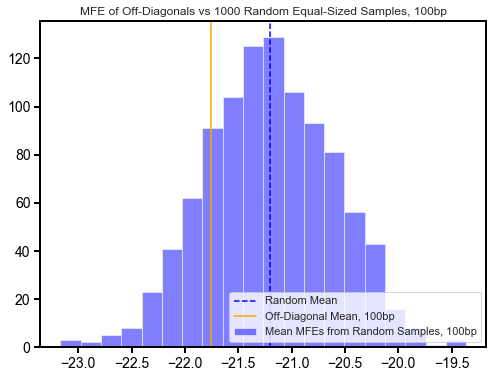

In [94]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop100_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 100bp')
ax.axvline(np.mean(pop100_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test100_mean,color='orange',label='Off-Diagonal Mean, 100bp')
ax.set_title("MFE of Off-Diagonals vs 1000 Random Equal-Sized Samples, 100bp")
ax.legend(loc='lower right')
print "Sample mean:", test100_mean
print "Population mean:", np.mean(pop100_means)

In [95]:
count_more_extreme100 = np.count_nonzero(pop100_means < test100_mean)
count_more_extreme100

185

In [104]:
n = (1-(count_more_extreme100/1000.0))*100
print "The mean MFE of the 45 off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement from the same population of sequences"


The mean MFE of the 45 off-diagonal sequences is lower than 81.5 % of the means 
 obtained by sampling randomly with replacement from the same population of sequences


### First 150 Base pairs

mean: -47.21777784559462 std: 4.4814824052300315


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 150 bp')

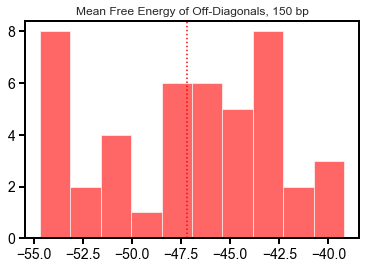

In [97]:
test150_values = data[data['is_offdiag'] == True]['mfe150'].values
test150_mean = np.mean(test150_values)
test150_std = np.std(test150_values)
print "mean:", test150_mean, "std:", test150_std
fig,ax = plt.subplots()
ax.hist(test150_values,color='red',bins=10,alpha=0.6)
ax.axvline(test150_mean,color='red',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 150 bp")

In [98]:
pop150_means = np.zeros(1000)
pop150_stds = np.zeros(1000)

np.random.seed(1339)
for i in range(1000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(shared_off_diagonals))
    mfes = data.iloc[indices]['mfe150'].values
    pop150_means[i],pop150_stds[i] = np.mean(mfes),np.std(mfes)


Sample mean: -47.21777784559462
Population mean: -47.08902311062283


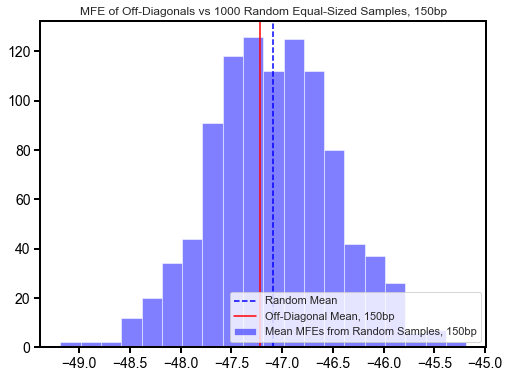

In [99]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop150_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 150bp')
ax.axvline(np.mean(pop150_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test150_mean,color='red',label='Off-Diagonal Mean, 150bp')
ax.set_title("MFE of Off-Diagonals vs 1000 Random Equal-Sized Samples, 150bp")
ax.legend(loc='lower right')
print "Sample mean:", test150_mean
print "Population mean:", np.mean(pop150_means)

In [100]:
count_more_extreme150 = np.count_nonzero(pop150_means < test150_mean)
count_more_extreme150

426

In [105]:
n = (1-(count_more_extreme150/1000.0))*100
print "The mean MFE of the 45 off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement from the same population of sequences"


The mean MFE of the 45 off-diagonal sequences is lower than 57.4 % of the means 
 obtained by sampling randomly with replacement from the same population of sequences


### Compare with the raw MFEs from everything, since we have the data

Text(0.5,1,'150bp')

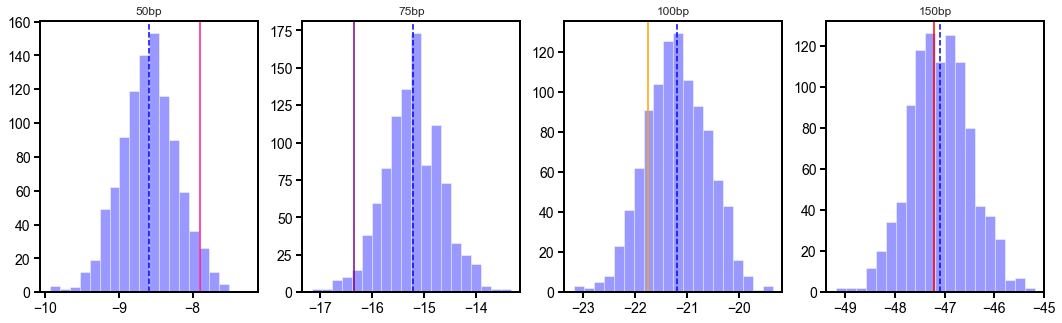

In [119]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(18,5))
ax1.hist(pop50_means,color='blue',alpha=0.4,bins=20)
ax1.axvline(np.mean(pop50_means),linestyle='--',color='blue')
ax1.axvline(test50_mean,color='deeppink')
ax1.set_title("50bp")
ax2.hist(pop75_means,color='blue',alpha=0.4,bins=20)
ax2.axvline(np.mean(pop75_means),linestyle='--',color='blue')
ax2.axvline(test75_mean,color='purple')
ax2.set_title("75bp")
ax3.hist(pop100_means,color='blue',alpha=0.4,bins=20)
ax3.axvline(np.mean(pop100_means),linestyle='--',color='blue')
ax3.axvline(test100_mean,color='orange')
ax3.set_title("100bp")
ax4.hist(pop150_means,color='blue',alpha=0.4,bins=20)
ax4.axvline(np.mean(pop150_means),linestyle='--',color='blue')
ax4.axvline(test150_mean,color='red')
ax4.set_title("150bp")

Text(0.5,1,'150bp')

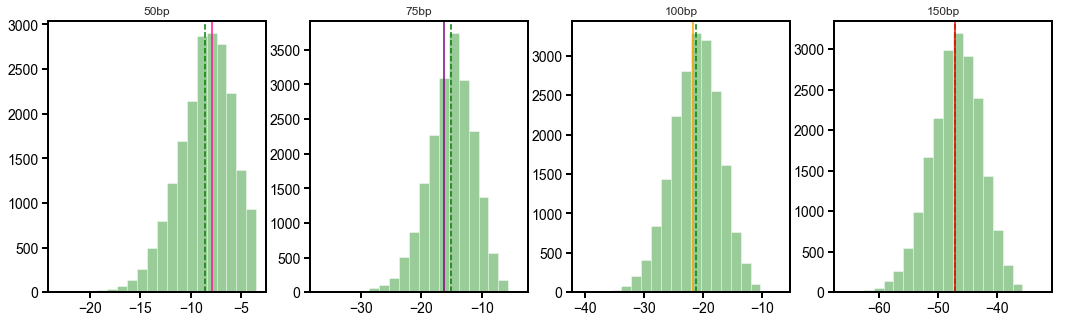

In [116]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(18,5))
ax1.hist(data['mfe50'].values,color='green',alpha=0.4,bins=20)
ax1.axvline(np.mean(data['mfe50'].values),linestyle='--',color='green')
ax1.axvline(test50_mean,color='deeppink')
ax1.set_title("50bp")
ax2.hist(data['mfe75'].values,color='green',alpha=0.4,bins=20)
ax2.axvline(np.mean(data['mfe75'].values),linestyle='--',color='green')
ax2.axvline(test75_mean,color='purple')
ax2.set_title("75bp")
ax3.hist(data['mfe100'].values,color='green',alpha=0.4,bins=20)
ax3.axvline(np.mean(data['mfe100'].values),linestyle='--',color='green')
ax3.axvline(test100_mean,color='orange')
ax3.set_title("100bp")
ax4.hist(data['mfe150'].values,color='green',alpha=0.4,bins=20)
ax4.axvline(np.mean(data['mfe150'].values),linestyle='--',color='green')
ax4.axvline(test150_mean,color='red')
ax4.set_title("150bp")

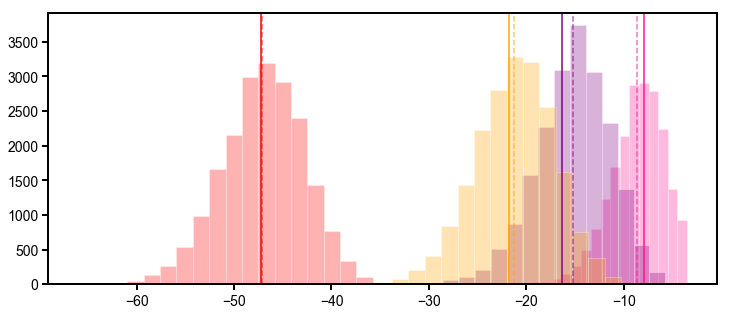

In [113]:
fig,ax = plt.subplots(figsize=(12,5))
ax.hist(data['mfe50'].values,color='deeppink',alpha=0.3,bins=20)
ax.axvline(np.mean(data['mfe50'].values),linestyle='--',color='deeppink',alpha=0.6)
ax.axvline(test50_mean,color='deeppink')
ax.hist(data['mfe75'].values,color='purple',alpha=0.3,bins=20)
ax.axvline(np.mean(data['mfe75'].values),linestyle='--',color='purple',alpha=0.6)
ax.axvline(test75_mean,color='purple')
ax.hist(data['mfe100'].values,color='orange',alpha=0.3,bins=20)
ax.axvline(np.mean(data['mfe100'].values),linestyle='--',color='orange',alpha=0.6)
ax.axvline(test100_mean,color='orange')
ax.hist(data['mfe150'].values,color='red',alpha=0.3,bins=20)
ax.axvline(np.mean(data['mfe150'].values),linestyle='--',color='red',alpha=0.6)
ax.axvline(test150_mean,color='red')

### Other Statistical Tests to Try: Mann-Whitney-U

In [74]:
# also try Mann-Whitney and Wilcoxon (nonparamatric!) Effect size is fn of mann-whitney u statistic: 2u/mn 
# where m and n are the set sizes

## Try Same Tests on Off-Diagonals from Full Dataset

In [150]:
# "pred" is the predictions from the model 'main_CNN_model.hdf5'
ods = pd.read_csv('../off_diagonal_utrs_author_model_all_data.csv',index_col=0)
print len(ods)
ods.head()

1276


,Unnamed: 0.1,utr,rl,scaled_rl,mfe75,mfe100,mfe125,pred
292,292,CCCCGAGGCTTGTGAGGAGTAAAACCCAAGAGAGGTAAAGTGCCACACAA,4.654325,-1.129277,-14.000000,-19.000000,-33.700001,7.726174
809,809,ATCGATCCACCCTGCATAGCAGGGAACTCTATTGTGCATGTTCGGATGCG,3.331041,-1.950308,-21.600000,-28.200001,-38.500000,6.763197
999,999,AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG,4.065457,-1.494640,-17.799999,-29.400000,-37.200001,6.719247
1046,1046,GCGAGGGAACAAGAGCAAAGGAGAATCTAGGCCACATCTCTCGTCGTTCC,4.038996,-1.511058,-16.000000,-20.799999,-32.000000,7.865101
1550,1550,CCCGACAATACTAGTGCTTTTAGGTATACACGCATAGTATGTTAACTGGT,5.111562,-0.845585,-11.300000,-16.799999,-29.600000,8.160692


In [130]:
#data = pd.read_csv('../mfe_dataset.csv',index_col=0)

## 75 bp

In [147]:
test75_values = ods['mfe75'].values
test75_mean = np.mean(test75_values)
test75_std = np.std(test75_values)
print "mean:", test75_mean, "std:", test75_std

mean: -15.04945144458998 std: 4.11644284078447


Text(0.5,1,'Mean Free Energy of All Off-Diagonals, 75 bp')

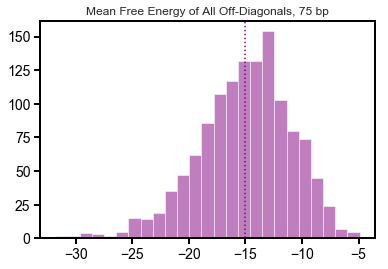

In [148]:
fig,ax = plt.subplots()
ax.hist(test75_values,color='purple',bins=25,alpha=0.5)
ax.axvline(test75_mean,color='purple',linestyle=":")
ax.set_title("Mean Free Energy of All Off-Diagonals, 75 bp")

In [151]:
pop75_means = np.zeros(10000)
pop75_stds = np.zeros(10000)

np.random.seed(1337)
for i in range(10000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(ods))
    mfes = data.iloc[indices]['mfe75'].values
    pop75_means[i],pop75_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


Sample mean: -15.04945144458998
Population mean: -15.040842965043842


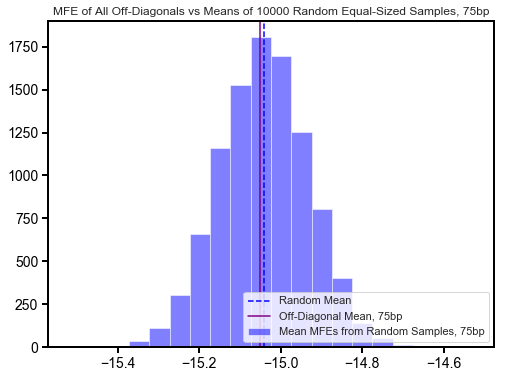

In [152]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop75_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 75bp')
ax.axvline(np.mean(pop75_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test75_mean,color='purple',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 10000 Random Equal-Sized Samples, 75bp")
ax.legend(loc='lower right')
print "Sample mean:", test75_mean
print "Population mean:", np.mean(pop75_means)

In [160]:
count_more_extreme75 = np.count_nonzero(pop75_means < test75_mean)
print count_more_extreme75
n = (1-(count_more_extreme75/10000.0))*100
print "The mean MFE of the first 75 bp of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


4691
The mean MFE of the first 75 bp of the 6155 total off-diagonal sequences is lower than 53.09 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences


## 100 bp

mean: -20.74801722140895 std: 4.203270369545972


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 100 bp')

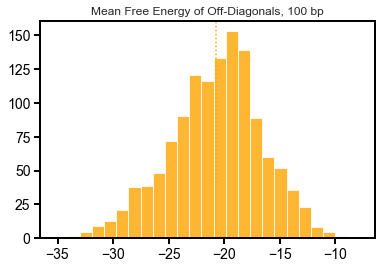

In [154]:
test100_values = ods['mfe100'].values
test100_mean = np.mean(test100_values)
test100_std = np.std(test100_values)
print "mean:", test100_mean, "std:", test100_std
fig,ax = plt.subplots()
ax.hist(test100_values,color='orange',bins=25,alpha=0.8)
ax.axvline(test100_mean,color='orange',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 100 bp")

In [155]:
pop100_means = np.zeros(10000)
pop100_stds = np.zeros(10000)

np.random.seed(1337)
for i in range(10000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(ods))
    mfes = data.iloc[indices]['mfe100'].values
    pop100_means[i],pop100_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


Sample mean: -20.74801722140895
Population mean: -20.61178055969372


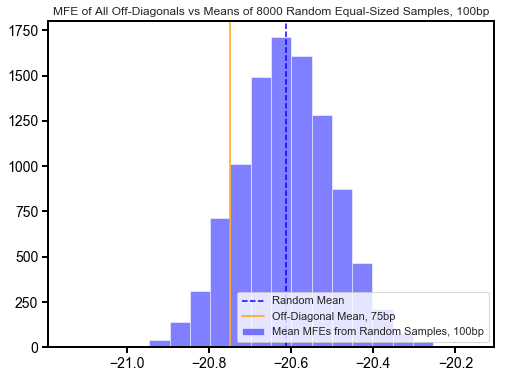

In [156]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop100_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 100bp')
ax.axvline(np.mean(pop100_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test100_mean,color='orange',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 8000 Random Equal-Sized Samples, 100bp")
ax.legend(loc='lower right')
print "Sample mean:", test100_mean
print "Population mean:", np.mean(pop100_means)

In [161]:
count_more_extreme100 = np.count_nonzero(pop100_means < test100_mean)
print count_more_extreme100
n = (1-(count_more_extreme100/10000.0))*100
print "The mean MFE of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


1214
The mean MFE of the 6155 total off-diagonal sequences is lower than 87.86 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences


## 125 bp

mean: -32.79858937009375 std: 4.420789914304064


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 125 bp')

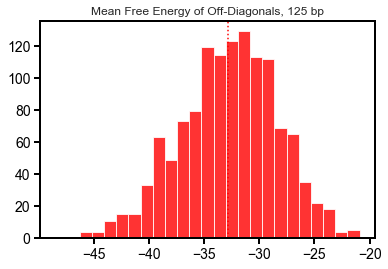

In [162]:
test125_values = ods['mfe125'].values
test125_mean = np.mean(test125_values)
test125_std = np.std(test125_values)
print "mean:", test125_mean, "std:", test125_std
fig,ax = plt.subplots()
ax.hist(test125_values,color='red',bins=25,alpha=0.8)
ax.axvline(test125_mean,color='red',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 125 bp")

In [163]:
pop125_means = np.zeros(10000)
pop125_stds = np.zeros(10000)

np.random.seed(1337)
for i in range(10000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(ods))
    mfes = data.iloc[indices]['mfe125'].values
    pop125_means[i],pop125_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


Sample mean: -32.79858937009375
Population mean: -32.718525249751906


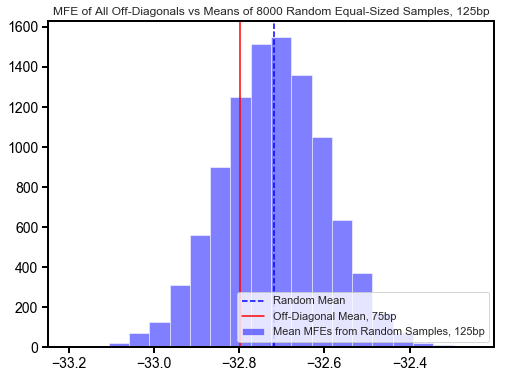

In [164]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop125_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 125bp')
ax.axvline(np.mean(pop125_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test125_mean,color='red',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 8000 Random Equal-Sized Samples, 125bp")
ax.legend(loc='lower right')
print "Sample mean:", test125_mean
print "Population mean:", np.mean(pop125_means)

In [165]:
count_more_extreme125 = np.count_nonzero(pop125_means < test125_mean)
print count_more_extreme125
n = (1-(count_more_extreme125/10000.0))*100
print "The mean MFE of the firt 125bp of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


2521
The mean MFE of the firt 125bp of the 6155 total off-diagonal sequences is lower than 74.79 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences
